In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
#!pip install torch torchvision
#import torch
from sklearn.svm import SVC

In [30]:
n_gen = 100
n_samples = 2*n_gen

In [94]:
data_blue = np.random.multivariate_normal(mean=np.array((-1,-1)), cov=np.eye(2)*0.5, size=n_gen)
data_red = np.random.multivariate_normal(mean=np.array((1,0.5)), cov=np.eye(2),size=n_gen)

/tmp/ipykernel_3592/1852211923.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_blue[:,0], data_blue[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_3592/1852211923.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(data_blue[:,0], data_blue[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_3592/1852211923.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_red[:,0], data_red[:,1], 'bo', marker='.', color='r')
/tmp/ipykernel_3592/1852211923.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  pl

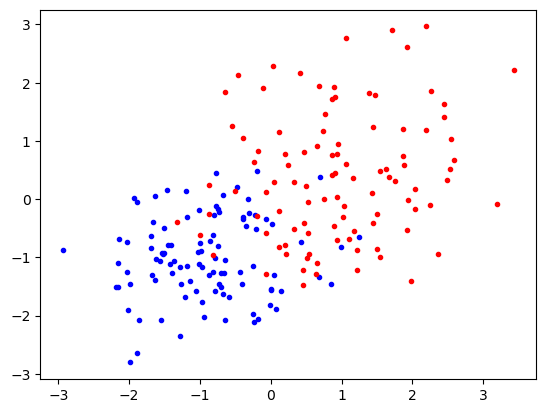

In [95]:
plt.plot(data_blue[:,0], data_blue[:,1], 'bo', marker='.', color='b')
plt.plot(data_red[:,0], data_red[:,1], 'bo', marker='.', color='r')

In [96]:
whole_data = np.vstack((data_blue,data_red))
labels = np.hstack((np.ones(n_gen)*-1,np.ones(n_gen)))

In [97]:
df = pd.DataFrame(whole_data)
df.columns = ['x1','x2']
df['labels'] = labels

In [98]:
whole_space_x = np.random.uniform(low=-4,high=4,size=10000)
whole_space_y = np.random.uniform(low=-3,high=3,size=10000)

In [99]:
whole_space_x = whole_space_x.reshape(10000,1)
whole_space_y = whole_space_y.reshape(10000,1)
whole_space = np.hstack((whole_space_x,whole_space_y))

In [100]:
svm_test = SVC(kernel='sigmoid',probability=True).fit(X=df.to_numpy()[:,:2],y=df.to_numpy()[:,2])

In [101]:
probas = svm_test.predict_proba(whole_space)

In [102]:
probas.shape

(10000, 2)

In [103]:
probas

array([[1.81860979e-08, 9.99999982e-01],
       [9.96547297e-01, 3.45270253e-03],
       [8.37370313e-01, 1.62629687e-01],
       ...,
       [9.70953407e-01, 2.90465930e-02],
       [1.47762995e-01, 8.52237005e-01],
       [9.96296366e-01, 3.70363408e-03]])

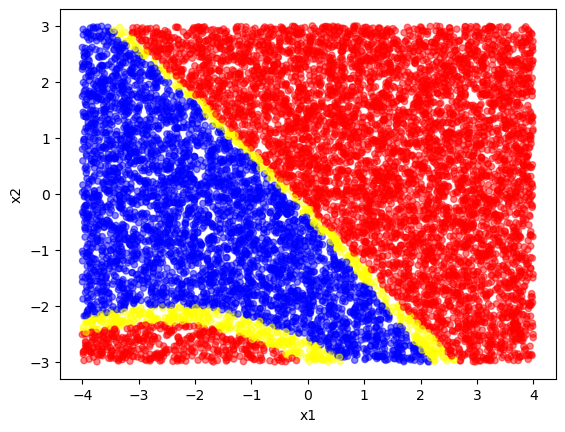

In [105]:
colors = np.empty(10000)
for i in range(10000):
    if probas[i,0]<=0.6 and probas[i,1]<=0.6:
        colors[i] = 0
    elif probas[i,0] >= probas[i,1]:
        colors[i] = -1
    else:
        colors[i] = 1

test_df = pd.DataFrame(whole_space)
test_df.columns = ['x1','x2']
test_df['colors'] = colors
colors = {0:'yellow',1:'red', -1:'blue'}
color_list = [colors[group] for group in test_df['colors']]
ax = test_df.plot.scatter('x1','x2', c=color_list,alpha=0.5)